## Libraries

In [1]:
import os
import obspy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from obspy.core.util import AttribDict
from obspy.imaging.cm import obspy_sequential
from obspy.signal.invsim import corn_freq_2_paz
from obspy.signal.array_analysis import array_processing

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Functions

In [3]:
# def __get_data(config):


#     config['subarray'] = []

#     st = Stream()

#     for k, station in enumerate(config['subarray_stations']):

#         net, sta = station.split(".")

#         if net == "II" and sta == "PFO":
#             loc, cha = "10", "BH*"
#         elif net == "PY" and sta == "PFOIX":
#             loc, cha = "", "HH*"
#         else:
#             loc, cha = "", "BH*"

#         print(f" -> requesting {net}.{sta}.{loc}.{cha}") if config['print_details'] else None


#         ## querry inventory data
#         try:
#             inventory = config['fdsn_client'].get_stations(
#                                                              network=net,
#                                                              station=sta,
#                                                              channel=cha,
#                                                              starttime=config['tbeg']-20,
#                                                              endtime=config['tend']+20,
#                                                             )
#         except:
#             print(" -> Failed to load inventory!")
#             inventory = None

#         ## try to get waveform data
#         try:
#             stats = config['fdsn_client'].get_waveforms(
#                                                         network=net,
#                                                         station=sta,
#                                                         location=loc,
#                                                         channel=cha,
#                                                         starttime=config['tbeg']-20,
#                                                         endtime=config['tend']+20,
#                                                         attach_response=True,
#                                                         )
#         except Exception as E:
#             print(E) if config['print_details'] else None
#             print(f" -> geting waveforms failed for {net}.{sta}.{loc}.{cha} ...") if config['print_details'] else None
#             continue



#         ## merge if masked
#         if len(stats) > 3:
#             print(f" -> merging stream. Length: {len(stats)} -> 3") if config['print_details'] else None
#             stats.merge(method=1, fill_value="interpolate")


#         ## sorting
#         stats.sort().reverse()


#         ## remove response [VEL -> rad/s | DISP -> rad]
#         stats.remove_response(output="VEL")


#         #correct mis-alignment
#         stats[0].data, stats[1].data, stats[2].data = rotate2zne(stats[0],0,-90,
#                                                                  stats[1],config['subarray_misorientation'][config['subarray_stations'].index(station)],0, 
#                                                                  stats[2],90+config['subarray_misorientation'][config['subarray_stations'].index(station)],0)


#         ## trim to interval
# #             stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

#         ## rotate to ZNE
#         try:
#             if "BPH" in sta:
#                 stats.rotate(method="->ZNE", inventory=inventory)
#         except:
#             print(" -> failed to rotate to ZNE")
#             continue

#         ## rename channels
#         if net == "II" and sta == "PFO":
#             for tr in stats:
#                 if tr.stats.channel[-1] == "1":
#                     tr.stats.channel = str(tr.stats.channel).replace("1","E")
#                 if tr.stats.channel[-1] == "2":
#                     tr.stats.channel = str(tr.stats.channel).replace("2","N")

#         if config['reference_station'] == "PY.PFOIX":
#             stats = stats.resample(40)
#             stats = stats.trim(config['tbeg']-20, config['tend']+20)


#         if station == config['reference_station']:
#             ref_station = stats.copy()

#         st += stats


#     print(st.__str__(extended=True)) if config['print_details'] else None

#     ## update subarray stations if data could not be requested for all stations
#     if len(st) < 3*len(config['subarray_stations']):
#         config['subarray_stations'] = [f"{tr.stats.network}.{tr.stats.station}" for tr in st]
#         config['subarray_stations'] = list(set(config['subarray_stations']))


#     print(f" -> obtained: {len(st)/3} of {len(config['subarray_stations'])} stations!") if config['print_details'] else None

#     if len(st) == 0:
#         return st, Stream(), config
#     else:
#         return st, ref_station, config

In [4]:
tbeg = "2022-12-31T12:12:27"
tend = "2022-12-31T12:13:00"
submask = "inner"

In [5]:
from functions.compute_beamforming_pfo import __compute_beamforming_pfo

 -> obtained: 5 of 5 stations!

 -> Runtime: 0.3 minutes


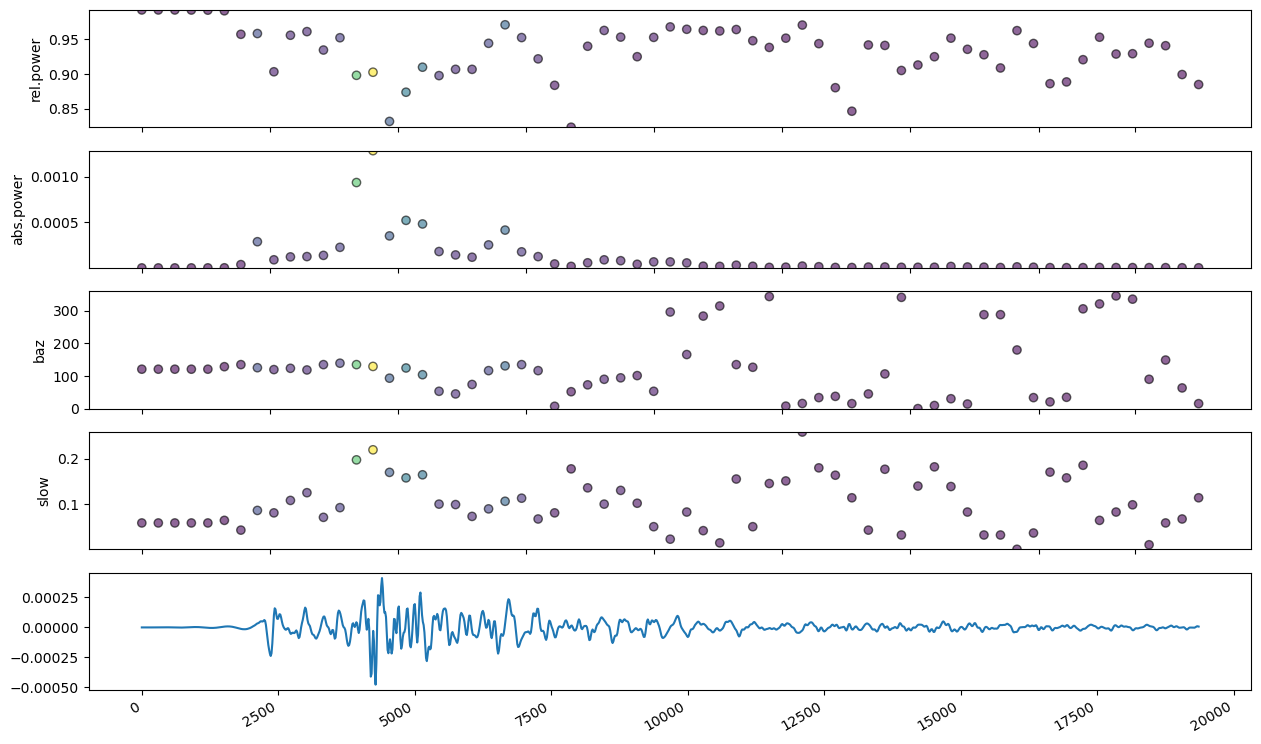

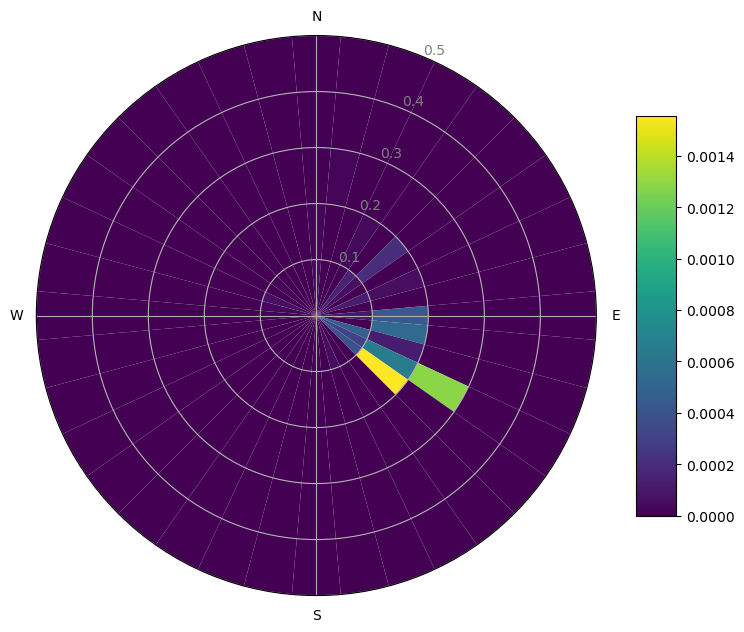

In [6]:
out_bf_i = __compute_beamforming_pfo(tbeg, tend, fmin=1, fmax=8, component="Z", submask="inner", plot=True)

 -> obtained: 13 of 13 stations!

 -> Runtime: 0.77 minutes


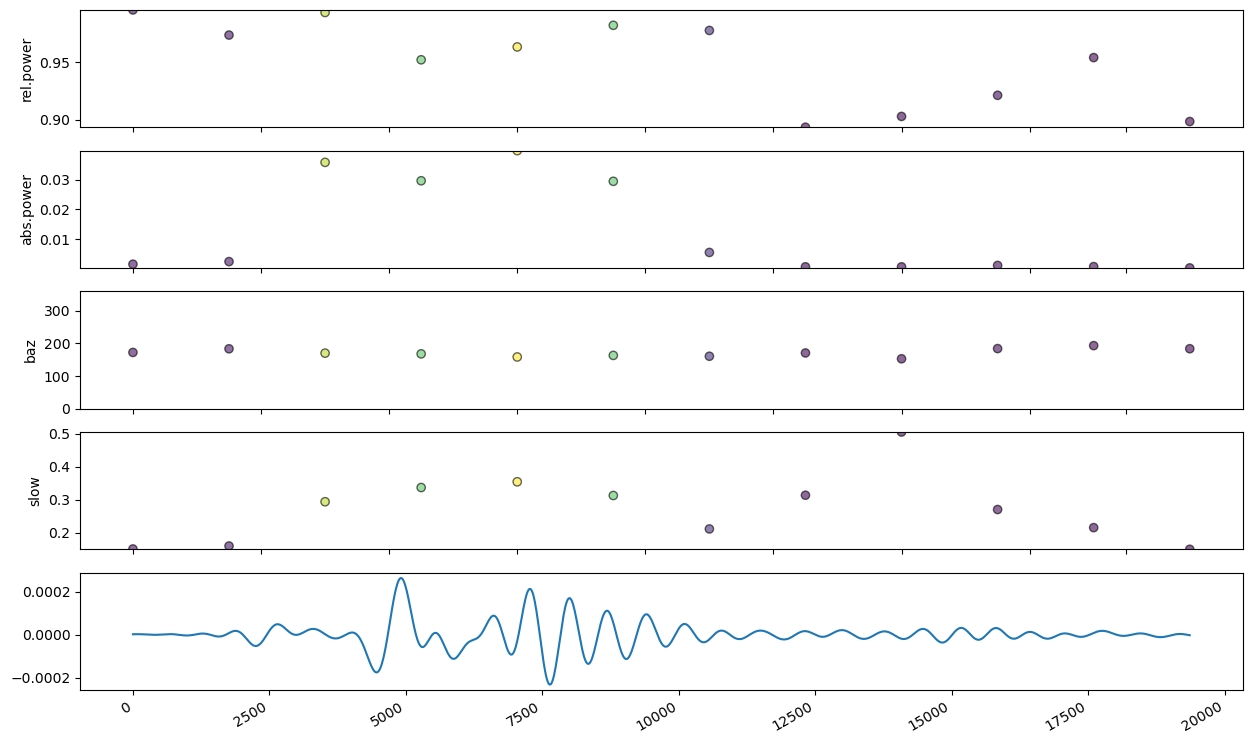

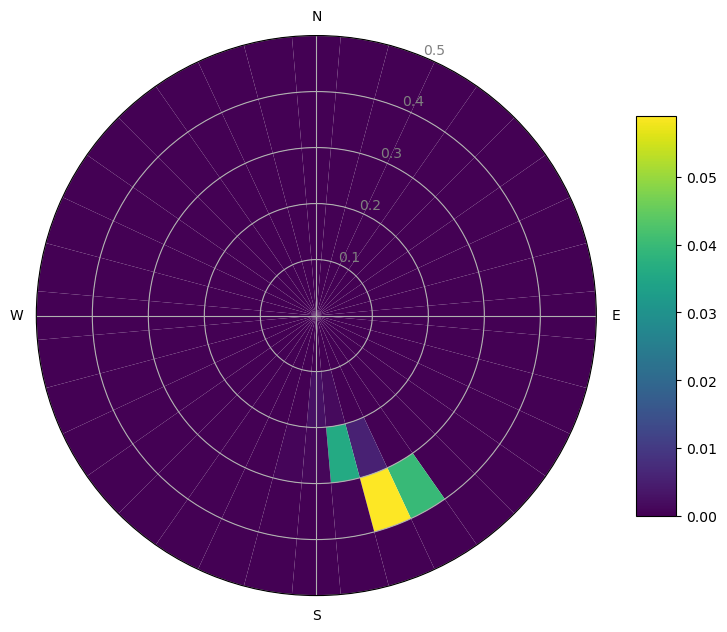

In [7]:
out_bf_a = __compute_beamforming_pfo(tbeg, tend, fmin=0.2, fmax=1.0, component="Z", submask="all", plot=True)

 -> obtained: 8 of 8 stations!

 -> Runtime: 0.48 minutes


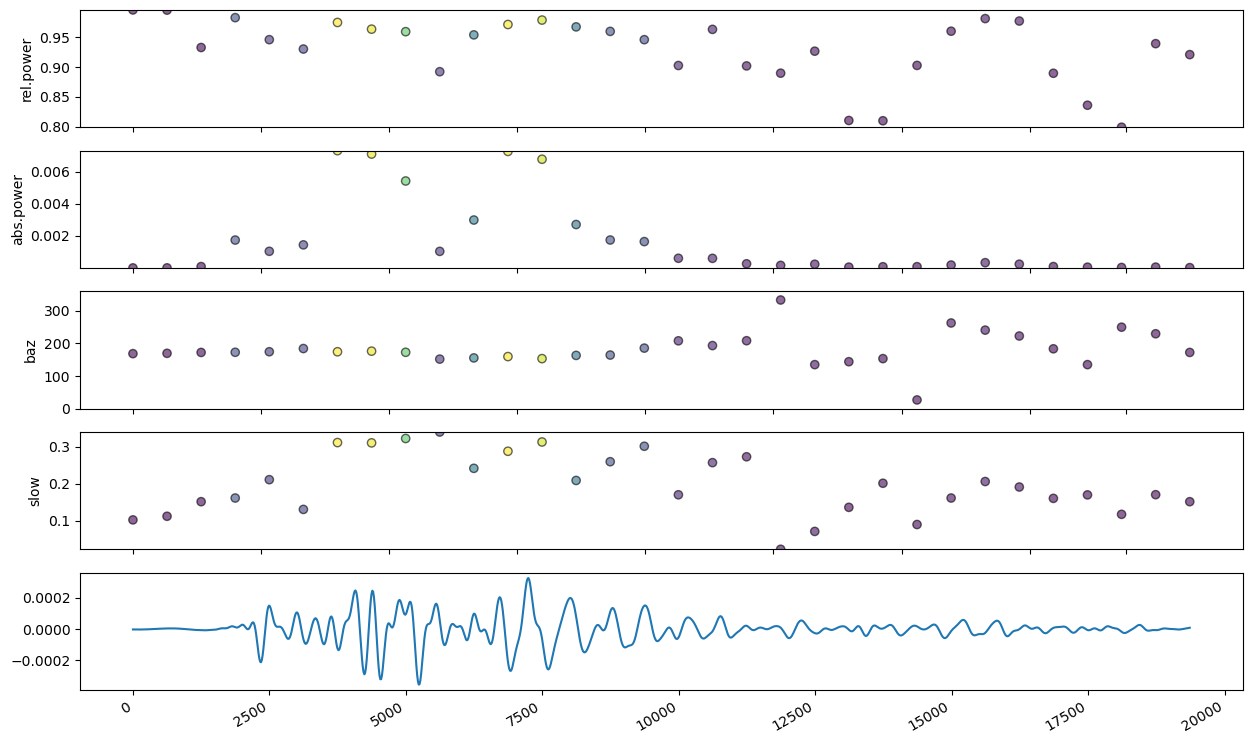

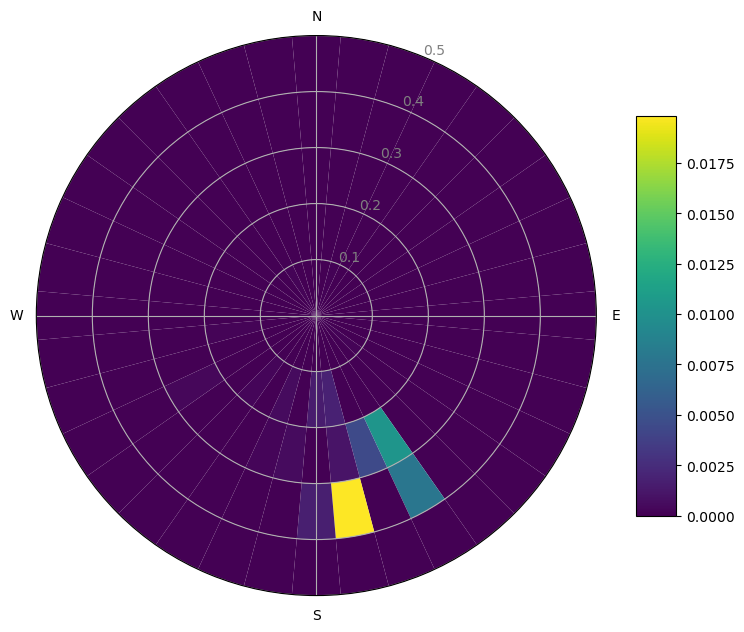

In [8]:
out_bf_m = __compute_beamforming_pfo(tbeg, tend, fmin=0.5, fmax=3.0, component="Z", submask="mid", plot=True)